##### Libraries

In [1]:
import numpy as np  # for numerical operations.

import pandas as pd  # for manipulation and analysis.

import seaborn as sns # for visualization.

import matplotlib.pyplot as plt # for visualization.

from sklearn.preprocessing import LabelEncoder # for encoding categorical variables.

from sklearn.preprocessing import StandardScaler # for standardizing numerical variables.

from sklearn.impute import SimpleImputer # for imputing missing values.

from sklearn.pipeline import make_pipeline # for creating pipelines.

from sklearn.linear_model import LogisticRegression # for logistic regression.

from sklearn.model_selection import train_test_split # for splitting data into training and testing sets.

from sklearn.ensemble import RandomForestClassifier # for random forest classifier.

from sklearn.metrics import classification_report, roc_auc_score # for evaluating model performance.

from xgboost import XGBClassifier # for XGBoost classifier.

from sklearn.model_selection import StratifiedKFold, cross_val_score # for cross-validation.

from sklearn.metrics import make_scorer, f1_score # for calculating F1 score.

import lightgbm as lgb # for LightGBM classifier.

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # for confusion matrix.

from sklearn.metrics import precision_recall_curve, average_precision_score # for precision-recall curve.

##### Loading datasets

In [2]:
# Load Train Dataset
Train_Provider = pd.read_excel('MFD Train.xlsx', sheet_name='Train_Provider')  # Load Provider Train Data.
Train_Beneficiarydata = pd.read_excel('MFD Train.xlsx', sheet_name='Train_Beneficiary_Data')  # Load Beneficiary Train Data.
Train_Inpatientdata = pd.read_excel('MFD Train.xlsx', sheet_name='Train_Inpatient_Data')  # Load Inpatient Train Data.
Train_Outpatientdata = pd.read_excel('MFD Train.xlsx', sheet_name='Train_Outpatient_Data')  # Load Outpatient Train Data.

# Load Test Dataset
Test_Provider = pd.read_excel("MFD Test.xlsx", sheet_name='Test_Provider')  # Load Provider Test Data.
Test_Beneficiarydata = pd.read_excel("MFD Test.xlsx", sheet_name='Test_Beneficiary_Data')  # Load Beneficiary Test Data.
Test_Inpatientdata = pd.read_excel('MFD Test.xlsx', sheet_name='Test_Inpatient_Data')  # Load Inpatient Test Data.
Test_Outpatientdata = pd.read_excel("MFD Test.xlsx", sheet_name='Test_Outpatient_Data')  # Load Outpatient Test Data.

##### Shape of the datasets

In [4]:
# Print shapes of train dataframes
print('Shape of Train data :', Train_Provider.shape)
print('Shape of Train_Beneficiarydata data :', Train_Beneficiarydata.shape)  
print('Shape of Train_Inpatientdata data :', Train_Inpatientdata.shape)  
print('Shape of Train_Outpatientdata data :', Train_Outpatientdata.shape)  
 

Shape of Train data : (5410, 2)
Shape of Train_Beneficiarydata data : (138556, 25)
Shape of Train_Inpatientdata data : (40474, 30)
Shape of Train_Outpatientdata data : (517737, 27)


##### .info()

In [5]:
# Check basic info
print(Test_Provider.info())
print(Test_Beneficiarydata.info())
print(Test_Inpatientdata.info())
print(Test_Outpatientdata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353 entries, 0 to 1352
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Provider  1353 non-null   object
dtypes: object(1)
memory usage: 10.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63968 entries, 0 to 63967
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   BeneID                           63968 non-null  object        
 1   DOB                              63968 non-null  datetime64[ns]
 2   DOD                              574 non-null    datetime64[ns]
 3   Gender                           63968 non-null  int64         
 4   Race                             63968 non-null  int64         
 5   RenalDiseaseIndicator            63968 non-null  object        
 6   State                            63968 non-null  int64         
 7  

##### Missing values

In [6]:
# Missing values summary 
def missing_values_summary(df, name):
    total = df.isnull().sum()
    percent = (total / len(df)) * 100
    missing_df = pd.DataFrame({
        'Total Missing': total,
        'Percent Missing': percent
    })
    print(f"\nMissing Values Summary for {name}:")
    print(missing_df[missing_df['Total Missing'] > 0])  

# Test:
missing_values_summary(Test_Provider, 'Test_Provider')
missing_values_summary(Test_Beneficiarydata, 'Test_Beneficiarydata')
missing_values_summary(Test_Inpatientdata, 'Test_Inpatientdata')
missing_values_summary(Test_Outpatientdata, 'Test_Outpatientdata')


Missing Values Summary for Test_Provider:
Empty DataFrame
Columns: [Total Missing, Percent Missing]
Index: []

Missing Values Summary for Test_Beneficiarydata:
     Total Missing  Percent Missing
DOD          63394        99.102676

Missing Values Summary for Test_Inpatientdata:
                     Total Missing  Percent Missing
AttendingPhysician              31         0.324573
OperatingPhysician            3962        41.482567
OtherPhysician                8538        89.393781
DeductibleAmtPaid              196         2.052141
ClmDiagnosisCode_2              54         0.565386
ClmDiagnosisCode_3             169         1.769448
ClmDiagnosisCode_4             404         4.229924
ClmDiagnosisCode_5             719         7.528008
ClmDiagnosisCode_6            1197        12.532719
ClmDiagnosisCode_7            1736        18.176107
ClmDiagnosisCode_8            2360        24.709455
ClmDiagnosisCode_9            3238        33.902209
ClmDiagnosisCode_10           8664        9

##### Summary of missing values

In [7]:
# Train
missing_values_summary(Train_Provider, 'Train_Provider')
missing_values_summary(Train_Beneficiarydata, 'Train_Beneficiarydata')
missing_values_summary(Train_Inpatientdata, 'Train_Inpatientdata')
missing_values_summary(Train_Outpatientdata, 'Train_Outpatientdata')


Missing Values Summary for Train_Provider:
Empty DataFrame
Columns: [Total Missing, Percent Missing]
Index: []

Missing Values Summary for Train_Beneficiarydata:
     Total Missing  Percent Missing
DOD         137135        98.974422

Missing Values Summary for Train_Inpatientdata:
                     Total Missing  Percent Missing
AttendingPhysician             112         0.276721
OperatingPhysician           16644        41.122696
OtherPhysician               35784        88.412314
DeductibleAmtPaid              899         2.221179
ClmDiagnosisCode_2             226         0.558383
ClmDiagnosisCode_3             676         1.670208
ClmDiagnosisCode_4            1534         3.790087
ClmDiagnosisCode_5            2894         7.150269
ClmDiagnosisCode_6            4838        11.953353
ClmDiagnosisCode_7            7258        17.932500
ClmDiagnosisCode_8            9942        24.563918
ClmDiagnosisCode_9           13497        33.347334
ClmDiagnosisCode_10          36547      

##### Dropping all columns with .90 threshold.

In [8]:
# Drop columns with threshold% missing
def drop_zero_info_cols(df, threshold=0.90, retain_cols=[]):

    missing_ratio = df.isnull().mean()
    cols_to_drop_missing = missing_ratio[missing_ratio >= threshold].index.tolist()
    
    # Drop zero variance columns
    zero_var_cols = [col for col in df.columns if df[col].nunique() <= 1]
    
    # Combine all columns to drop
    cols_to_drop = list(set(cols_to_drop_missing + zero_var_cols))
    
    # Exclude columns to retain
    cols_to_drop = [col for col in cols_to_drop if col not in retain_cols]
    
    print(f"Dropping {len(cols_to_drop)} columns: {cols_to_drop}")
    
    df_cleaned = df.drop(columns=cols_to_drop)
    
    return df_cleaned


retain_cols = ['OtherPhysician']

train_inpatient_cleaned = drop_zero_info_cols(Train_Inpatientdata, threshold=0.90, retain_cols=retain_cols)
train_outpatient_cleaned = drop_zero_info_cols(Train_Outpatientdata, threshold=0.90, retain_cols=retain_cols)

test_inpatient_cleaned = drop_zero_info_cols(Test_Inpatientdata, threshold=0.90, retain_cols=retain_cols)
test_outpatient_cleaned = drop_zero_info_cols(Test_Outpatientdata, threshold=0.90, retain_cols=retain_cols)


Dropping 6 columns: ['ClmProcedureCode_3', 'ClmDiagnosisCode_10', 'ClmProcedureCode_4', 'ClmProcedureCode_6', 'DeductibleAmtPaid', 'ClmProcedureCode_5']
Dropping 11 columns: ['ClmDiagnosisCode_6', 'ClmProcedureCode_3', 'ClmDiagnosisCode_10', 'ClmDiagnosisCode_9', 'ClmProcedureCode_4', 'ClmProcedureCode_2', 'ClmProcedureCode_6', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_7', 'ClmProcedureCode_5', 'ClmProcedureCode_1']
Dropping 6 columns: ['ClmProcedureCode_3', 'ClmDiagnosisCode_10', 'ClmProcedureCode_4', 'ClmProcedureCode_6', 'DeductibleAmtPaid', 'ClmProcedureCode_5']
Dropping 11 columns: ['ClmDiagnosisCode_6', 'ClmProcedureCode_3', 'ClmDiagnosisCode_10', 'ClmDiagnosisCode_9', 'ClmProcedureCode_4', 'ClmProcedureCode_2', 'ClmProcedureCode_6', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_7', 'ClmProcedureCode_5', 'ClmProcedureCode_1']


##### Categorical variables

In [9]:
# Check categorical columns
categorical_cols_inpatient = train_inpatient_cleaned.select_dtypes(include='object').columns
categorical_cols_outpatient = train_outpatient_cleaned.select_dtypes(include='object').columns

print("Inpatient Categorical Columns:", categorical_cols_inpatient)
print("Outpatient Categorical Columns:", categorical_cols_outpatient)

Inpatient Categorical Columns: Index(['BeneID', 'ClaimID', 'Provider', 'AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'ClmAdmitDiagnosisCode',
       'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9'],
      dtype='object')
Outpatient Categorical Columns: Index(['BeneID', 'ClaimID', 'Provider', 'AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmAdmitDiagnosisCode'],
      dtype='object')


##### % of missing values in each column

In [10]:
# Print no of entries missing and corresponding percentages
def check_null_empty_percentage(df, cat_cols, name=''):
    print(f"{name} - Missing/Empty Summary:")
    total = len(df)
    for col in cat_cols:
        nulls = df[col].isnull().sum()
        empties = (df[col] == '').sum()
        total_missing = nulls + empties
        percent = (total_missing / total) * 100
        print(f"{col}: {total_missing} missing/empty ({percent:.2f}%)")
    print('-' * 50)

# Train Inpatient
check_null_empty_percentage(train_inpatient_cleaned, categorical_cols_inpatient, 'Train Inpatient')

# Test Inpatient
check_null_empty_percentage(test_inpatient_cleaned, categorical_cols_inpatient, 'Test Inpatient')

# Train Outpatient
check_null_empty_percentage(train_outpatient_cleaned, categorical_cols_outpatient, 'Train Outpatient')

# Test Outpatient
check_null_empty_percentage(test_outpatient_cleaned, categorical_cols_outpatient, 'Test Outpatient')


Train Inpatient - Missing/Empty Summary:
BeneID: 0 missing/empty (0.00%)
ClaimID: 0 missing/empty (0.00%)
Provider: 0 missing/empty (0.00%)
AttendingPhysician: 112 missing/empty (0.28%)
OperatingPhysician: 16644 missing/empty (41.12%)
OtherPhysician: 35784 missing/empty (88.41%)
ClmAdmitDiagnosisCode: 0 missing/empty (0.00%)
DiagnosisGroupCode: 0 missing/empty (0.00%)
ClmDiagnosisCode_1: 0 missing/empty (0.00%)
ClmDiagnosisCode_2: 226 missing/empty (0.56%)
ClmDiagnosisCode_3: 676 missing/empty (1.67%)
ClmDiagnosisCode_4: 1534 missing/empty (3.79%)
ClmDiagnosisCode_5: 2894 missing/empty (7.15%)
ClmDiagnosisCode_6: 4838 missing/empty (11.95%)
ClmDiagnosisCode_7: 7258 missing/empty (17.93%)
ClmDiagnosisCode_8: 9942 missing/empty (24.56%)
ClmDiagnosisCode_9: 13497 missing/empty (33.35%)
--------------------------------------------------
Test Inpatient - Missing/Empty Summary:
BeneID: 0 missing/empty (0.00%)
ClaimID: 0 missing/empty (0.00%)
Provider: 0 missing/empty (0.00%)
AttendingPhysici

##### Imputation of missing values

In [11]:
def impute(df):
    
    # Renal Disease Indicator Encoding
    if 'RenalDiseaseIndicator' in df.columns:
        df['RenalDiseaseIndicator'] = df['RenalDiseaseIndicator'].replace({'Y': 1, 'N': 0, 0: 0, 1: 1}).fillna(0).astype(int)
    
    # Mode imputation for Diagnosis Codes
    diagnosis_cols = [col for col in df.columns if 'ClmDiagnosisCode' in col or 'ClmAdmitDiagnosisCode' in col]
    for col in diagnosis_cols:
        mode_val = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
        df[col] = df[col].fillna(mode_val)
    
    # 'Unknown' for missing OperatingPhysician & OtherPhysician
    physician_cols = ['OperatingPhysician', 'OtherPhysician']
    for col in physician_cols:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown')
    
    # Replace empty strings in physician columns with 'Missing'
    for col in physician_cols:
        if col in df.columns:
            df[col] = df[col].replace('', 'Missing')
    
    # 4. AttendingPhysician, minimal missing values — fill with mode
    if 'AttendingPhysician' in df.columns:
        mode_val = df['AttendingPhysician'].mode()[0] if not df['AttendingPhysician'].mode().empty else 'Unknown'
        df['AttendingPhysician'] = df['AttendingPhysician'].fillna(mode_val)
    
    return df

##### Column lists and imputation

In [12]:
physician_cols = ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']
diagnosis_cols_inpatient = ['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
                            'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
                            'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9']

diagnosis_cols_outpatient = ['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
                             'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmAdmitDiagnosisCode']

# Inpatient
train_inpatient_cleaned = impute(train_inpatient_cleaned)
test_inpatient_cleaned = impute(test_inpatient_cleaned)

# Outpatient
train_outpatient_cleaned = impute(train_outpatient_cleaned)
test_outpatient_cleaned = impute(test_outpatient_cleaned)


# Beneficiary Data
train_beneficiary_cleaned = impute(Train_Beneficiarydata)
test_beneficiary_cleaned = impute(Test_Beneficiarydata)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_2508\3228278678.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RenalDiseaseIndicator'] = df['RenalDiseaseIndicator'].replace({'Y': 1, 'N': 0, 0: 0, 1: 1}).fillna(0).astype(int)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2508\3228278678.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RenalDiseaseIndicator'] = df['RenalDiseaseIndicator'].replace({'Y': 1, 'N': 0, 0: 0, 1: 1}).fillna(0).astype(int)


##### Quick glance at first few records

In [13]:
Test_Provider.head()

,Provider
0,PRV51002
1,PRV51006
2,PRV51009
3,PRV51010
4,PRV51018


In [14]:
Test_Beneficiarydata.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaT,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11007,1940-09-01,2009-12-01,1,2,0,45,610,12,12,...,2,1,2,1,1,2,0,0,1490,160
2,BENE11010,1936-07-01,NaT,2,1,0,41,30,12,12,...,2,1,1,1,2,2,0,0,1170,660
3,BENE11011,1914-03-01,NaT,2,2,0,1,360,12,12,...,1,1,2,2,1,1,5000,1068,250,320
4,BENE11014,1938-04-01,NaT,2,1,1,45,780,12,12,...,1,2,1,2,2,2,21260,2136,120,100


In [15]:
test_inpatient_cleaned.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmProcedureCode_1,ClmProcedureCode_2
0,BENE11014,CLM67387,2009-09-09,2009-09-16,PRV57070,9000,PHY317786,PHY427017,Unknown,2009-09-09,...,5533,496,V420,40390,2851,5990,570,41071,4443.0,5849.0
1,BENE11017,CLM31237,2008-12-25,2009-01-08,PRV54750,14000,PHY314656,PHY426644,Unknown,2008-12-25,...,41071,5990,5601,4588,5845,4549,29570,34831,5551.0,NaN
2,BENE11026,CLM78930,2009-12-09,2009-12-13,PRV53758,2000,PHY349495,Unknown,Unknown,2009-12-09,...,78791,60000,41401,V1254,4372,78650,7813,4254,NaN,NaN
3,BENE11031,CLM56810,2009-06-23,2009-07-06,PRV55825,16000,PHY429538,PHY371893,Unknown,2009-06-23,...,4168,920,5990,40391,2859,4254,41400,5849,8152.0,3320.0
4,BENE11085,CLM34625,2009-01-20,2009-01-31,PRV52338,19000,PHY397161,Unknown,Unknown,2009-01-20,...,V142,78702,30503,V140,V4582,V6109,7242,4019,NaN,NaN


In [16]:
test_outpatient_cleaned.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11001,CLM392397,2009-06-02,2009-06-02,PRV55962,30,PHY347633,Unknown,PHY347633,V5832,V5861,2724,3182,V5869,0,V7612
1,BENE11001,CLM430760,2009-06-23,2009-06-23,PRV56112,30,PHY381777,Unknown,PHY381777,9594,E9174,4019,4019,4019,0,V7612
2,BENE11007,CLM233081,2009-03-07,2009-03-07,PRV56979,200,PHY425311,Unknown,PHY425311,7248,4019,4019,4019,4019,0,V7612
3,BENE11007,CLM496381,2009-07-29,2009-07-29,PRV56573,10,PHY393253,PHY347995,Unknown,58889,2449,4019,4019,4019,0,5939
4,BENE11007,CLM521391,2009-08-12,2009-08-12,PRV56573,10,PHY417685,Unknown,PHY382041,V666,4019,4019,4019,4019,0,V7612


In [17]:
train_inpatient_cleaned.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmProcedureCode_1,ClmProcedureCode_2
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,Unknown,Unknown,2009-04-12,...,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,Unknown,2009-08-31,...,2948,56400,4019,4019,4019,4019,4019,4019,7092.0,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,Unknown,PHY324689,2009-09-17,...,30390,71690,34590,V1581,32723,4019,4019,4019,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,2762,7843,32723,V1041,4254,25062,40390,4019,331.0,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,Unknown,2009-08-13,...,3051,34400,5856,42732,486,5119,29620,20300,3893.0,NaN


In [18]:
train_outpatient_cleaned.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,Unknown,Unknown,78943,V5866,V1272,4019,4019,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,Unknown,Unknown,6115,4019,4019,4019,4019,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,Unknown,Unknown,2723,4019,4019,4019,4019,0,V7612
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,Unknown,Unknown,71988,4019,4019,4019,4019,0,V7612
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,Unknown,Unknown,82382,30000,72887,4280,7197,0,71947


##### Shape of imputed datasets

In [19]:
# shapes of Test dataframes
print('Shape of Test_Provider:', Test_Provider.shape)
print('Shape of Test_Beneficiarydata:', test_beneficiary_cleaned.shape)
print('Shape of test_inpatient_cleaned:', test_inpatient_cleaned.shape)
print('Shape of test_outpatient_cleaned:', test_outpatient_cleaned.shape)

# shapes of Train dataframes
print('Shape of Train_Provider:', Train_Provider.shape)
print('Shape of Train_Beneficiarydata:', train_beneficiary_cleaned.shape)
print('Shape of train_inpatient_cleaned:', train_inpatient_cleaned.shape)
print('Shape of train_outpatient_cleaned:', train_outpatient_cleaned.shape)

Shape of Test_Provider: (1353, 1)
Shape of Test_Beneficiarydata: (63968, 25)
Shape of test_inpatient_cleaned: (9551, 24)
Shape of test_outpatient_cleaned: (125841, 16)
Shape of Train_Provider: (5410, 2)
Shape of Train_Beneficiarydata: (138556, 25)
Shape of train_inpatient_cleaned: (40474, 24)
Shape of train_outpatient_cleaned: (517737, 16)


In [20]:
# shape and sample of Train data
print(f"Train Shape: {Train_Provider.shape}\n")
print("Train Sample:\n", Train_Provider.head())

# shape and sample of Test data
print(f"\nTest Shape: {Test_Provider.shape}\n")
print("Test Sample:\n", Test_Provider.head())


Train Shape: (5410, 2)

Train Sample:
    Provider PotentialFraud
0  PRV51001             No
1  PRV51003            Yes
2  PRV51004             No
3  PRV51005            Yes
4  PRV51007             No

Test Shape: (1353, 1)

Test Sample:
    Provider
0  PRV51002
1  PRV51006
2  PRV51009
3  PRV51010
4  PRV51018


##### Duplicates

In [21]:
# Checking for duplicates
def check_provider_duplicates(df, dataset_name):
    if 'Provider' not in df.columns:
        print(f"'{dataset_name}' dataset does not have a 'Provider' column.")
        return

    # Count provider occurrences
    provider_counts = df['Provider'].value_counts()

    # Print provider counts
    print(f"\n{'='*40}")
    print(f"{dataset_name} Provider Counts:")
    print(provider_counts)

    # Check for duplicates
    has_duplicates = (provider_counts > 1).any()

    if has_duplicates:
        print(f"\nDuplicates found in {dataset_name} Provider column.")
        print(f"Providers with multiple entries:")
        print(provider_counts[provider_counts > 1])
    else:
        print(f"\nNo duplicates found in {dataset_name} Provider column.")
    print(f"{'='*40}")

# Train:
check_provider_duplicates(Train_Provider, "Train")

# Test:
check_provider_duplicates(Test_Provider, "Test")



Train Provider Counts:
Provider
PRV51001    1
PRV55516    1
PRV55527    1
PRV55525    1
PRV55523    1
           ..
PRV53246    1
PRV53245    1
PRV53244    1
PRV53243    1
PRV57763    1
Name: count, Length: 5410, dtype: int64

No duplicates found in Train Provider column.

Test Provider Counts:
Provider
PRV51002    1
PRV55422    1
PRV55484    1
PRV55478    1
PRV55476    1
           ..
PRV53275    1
PRV53273    1
PRV53271    1
PRV53270    1
PRV57750    1
Name: count, Length: 1353, dtype: int64

No duplicates found in Test Provider column.


##### Grouping columns by dta types

In [22]:
import inspect

def group_columns_by_dtype(df):
    # Get variable name
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    df_name = [var_name for var_name, var_val in callers_local_vars if var_val is df]
    df_name = df_name[0] if df_name else 'DataFrame'
    
    print(f"\n{'='*40}")
    print(f"Data Types Summary for {df_name}:")
    print(f"{'='*40}\n")
    
    # Get unique data types in dataframe
    data_types = df.dtypes.unique()
    
    # Loop over each unique dtype
    for dtype in data_types:
        # Get column names for current data type
        cols = df.select_dtypes(include=[dtype]).columns.tolist()
        
        print(f"Data Type: {dtype}")
        print(f"Columns ({len(cols)} columns): {cols}\n")

# Dictionary of datasets
datasets = {
    "Train_Provider": Train_Provider,
    "Test_Provider": Test_Provider,
    "Train_Beneficiarydata": train_beneficiary_cleaned,
    "Test_Beneficiarydata": test_beneficiary_cleaned,
    "Train_Inpatientdata": train_inpatient_cleaned,
    "Test_Inpatientdata": test_inpatient_cleaned,
    "Train_Outpatientdata": train_outpatient_cleaned,
    "Test_Outpatientdata": test_outpatient_cleaned,
}

# Loop through datasets
for name, df in datasets.items():
    group_columns_by_dtype(df)


Data Types Summary for Train_Provider:

Data Type: object
Columns (2 columns): ['Provider', 'PotentialFraud']


Data Types Summary for Test_Provider:

Data Type: object
Columns (1 columns): ['Provider']


Data Types Summary for Train_Beneficiarydata:

Data Type: object
Columns (1 columns): ['BeneID']

Data Type: datetime64[ns]
Columns (2 columns): ['DOB', 'DOD']

Data Type: int64
Columns (21 columns): ['Gender', 'Race', 'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt']

Data Type: int32
Columns (1 columns): ['RenalDiseaseIndicator']


Data Types Summary for Test_Beneficiary

##### Merging Datasets

In [23]:
def merge_datasets(train_inpatient_cleaned, test_inpatient_cleaned,
                   train_outpatient_cleaned, test_outpatient_cleaned,
                   train_beneficiary_cleaned, test_beneficiary_cleaned,
                   provider_data=None):

    # Merge Inpatient with Beneficiary
    train_inpatient_merged = pd.merge(train_inpatient_cleaned, train_beneficiary_cleaned, on='BeneID', how='left')
    test_inpatient_merged = pd.merge(test_inpatient_cleaned, test_beneficiary_cleaned, on='BeneID', how='left')
    
    # Merge Outpatient with Beneficiary
    train_outpatient_merged = pd.merge(train_outpatient_cleaned, train_beneficiary_cleaned, on='BeneID', how='left')
    test_outpatient_merged = pd.merge(test_outpatient_cleaned, test_beneficiary_cleaned, on='BeneID', how='left')
    
    # Combine Inpatient and Outpatient for Train and Test separately
    train_combined = pd.concat([train_inpatient_merged, train_outpatient_merged], axis=0, ignore_index=True)
    test_combined = pd.concat([test_inpatient_merged, test_outpatient_merged], axis=0, ignore_index=True)
    
    # Optionally merge with Provider data (only applicable for Train)
    if provider_data is not None:
        train_combined = pd.merge(train_combined, provider_data, on='Provider', how='left')
    
    return train_combined, test_combined


In [24]:
Train_Combined, Test_Combined = merge_datasets(
    train_inpatient_cleaned, test_inpatient_cleaned,
    train_outpatient_cleaned, test_outpatient_cleaned,
    train_beneficiary_cleaned, test_beneficiary_cleaned,
    Train_Provider   # Only provider data for Train, leave Test without provider
)
# Check outputs
print(f"Train Combined Shape: {Train_Combined.shape}")
print(f"Test Combined Shape: {Test_Combined.shape}")

Train_Combined.head()


Train Combined Shape: (558211, 50)
Test Combined Shape: (135392, 49)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,DeductibleAmtPaid,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,Unknown,Unknown,2009-04-12,...,1,2,1,1,36000,3204,60,70,NaN,Yes
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,Unknown,2009-08-31,...,1,2,1,1,36000,3204,60,70,NaN,No
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,Unknown,PHY324689,2009-09-17,...,1,2,1,1,36000,3204,60,70,NaN,No
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,2,2,1,1,5000,1068,250,320,NaN,No
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,Unknown,2009-08-13,...,1,2,2,2,21260,2136,120,100,NaN,No


In [25]:
Test_Combined.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,DeductibleAmtPaid
0,BENE11014,CLM67387,2009-09-09,2009-09-16,PRV57070,9000,PHY317786,PHY427017,Unknown,2009-09-09,...,2,1,2,2,2,21260,2136,120,100,NaN
1,BENE11017,CLM31237,2008-12-25,2009-01-08,PRV54750,14000,PHY314656,PHY426644,Unknown,2008-12-25,...,1,1,2,1,1,22000,2136,1400,840,NaN
2,BENE11026,CLM78930,2009-12-09,2009-12-13,PRV53758,2000,PHY349495,Unknown,Unknown,2009-12-09,...,2,1,2,2,2,2000,1068,0,0,NaN
3,BENE11031,CLM56810,2009-06-23,2009-07-06,PRV55825,16000,PHY429538,PHY371893,Unknown,2009-06-23,...,2,1,1,2,2,23650,2136,40,0,NaN
4,BENE11085,CLM34625,2009-01-20,2009-01-31,PRV52338,19000,PHY397161,Unknown,Unknown,2009-01-20,...,1,1,1,2,2,19000,1068,1670,520,NaN


In [26]:
# For Train
print(f"Number of duplicate rows in Train: {Train_Combined.duplicated().sum()}")

# For Test
print(f"Number of duplicate rows in Test: {Test_Combined.duplicated().sum()}")

Number of duplicate rows in Train: 0
Number of duplicate rows in Test: 0


In [27]:
# Date format
date_cols = ['ClaimStartDt', 'ClaimEndDt', 'DOB', 'DOD']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

In [28]:
Test_Combined.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,DeductibleAmtPaid
0,BENE11014,CLM67387,2009-09-09,2009-09-16,PRV57070,9000,PHY317786,PHY427017,Unknown,2009-09-09,...,2,1,2,2,2,21260,2136,120,100,NaN
1,BENE11017,CLM31237,2008-12-25,2009-01-08,PRV54750,14000,PHY314656,PHY426644,Unknown,2008-12-25,...,1,1,2,1,1,22000,2136,1400,840,NaN
2,BENE11026,CLM78930,2009-12-09,2009-12-13,PRV53758,2000,PHY349495,Unknown,Unknown,2009-12-09,...,2,1,2,2,2,2000,1068,0,0,NaN
3,BENE11031,CLM56810,2009-06-23,2009-07-06,PRV55825,16000,PHY429538,PHY371893,Unknown,2009-06-23,...,2,1,1,2,2,23650,2136,40,0,NaN
4,BENE11085,CLM34625,2009-01-20,2009-01-31,PRV52338,19000,PHY397161,Unknown,Unknown,2009-01-20,...,1,1,1,2,2,19000,1068,1670,520,NaN


In [29]:
Train_Combined.head(100)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,DeductibleAmtPaid,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,Unknown,Unknown,2009-04-12,...,1,2,1,1,36000,3204,60,70,NaN,Yes
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,Unknown,2009-08-31,...,1,2,1,1,36000,3204,60,70,NaN,No
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,Unknown,PHY324689,2009-09-17,...,1,2,1,1,36000,3204,60,70,NaN,No
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,2,2,1,1,5000,1068,250,320,NaN,No
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,Unknown,2009-08-13,...,1,2,2,2,21260,2136,120,100,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,BENE11337,CLM58991,2009-07-09,2009-07-17,PRV53808,11000,PHY362864,Unknown,Unknown,2009-07-09,...,1,2,2,2,11000,1068,0,0,NaN,Yes
96,BENE11340,CLM33113,2009-01-09,2009-01-10,PRV51178,20000,PHY351542,Unknown,Unknown,2009-01-09,...,1,1,1,2,31000,3204,0,0,NaN,Yes
97,BENE11340,CLM35457,2009-01-25,2009-02-12,PRV51159,7000,PHY422690,Unknown,Unknown,2009-01-25,...,1,1,1,2,31000,3204,0,0,NaN,Yes
98,BENE11340,CLM70157,2009-09-30,2009-10-03,PRV51159,4000,PHY422690,Unknown,Unknown,2009-09-30,...,1,1,1,2,31000,3204,0,0,NaN,Yes


##### Relevant Columns for Correlation

In [30]:
# Select numerical columns
numerical_cols = Train_Combined.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Print to check
print(numerical_cols)

['InscClaimAmtReimbursed', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'Gender', 'Race', 'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'DeductibleAmtPaid']


In [31]:
# Correlation Matrix
corr_matrix = Train_Combined[numerical_cols].corr()

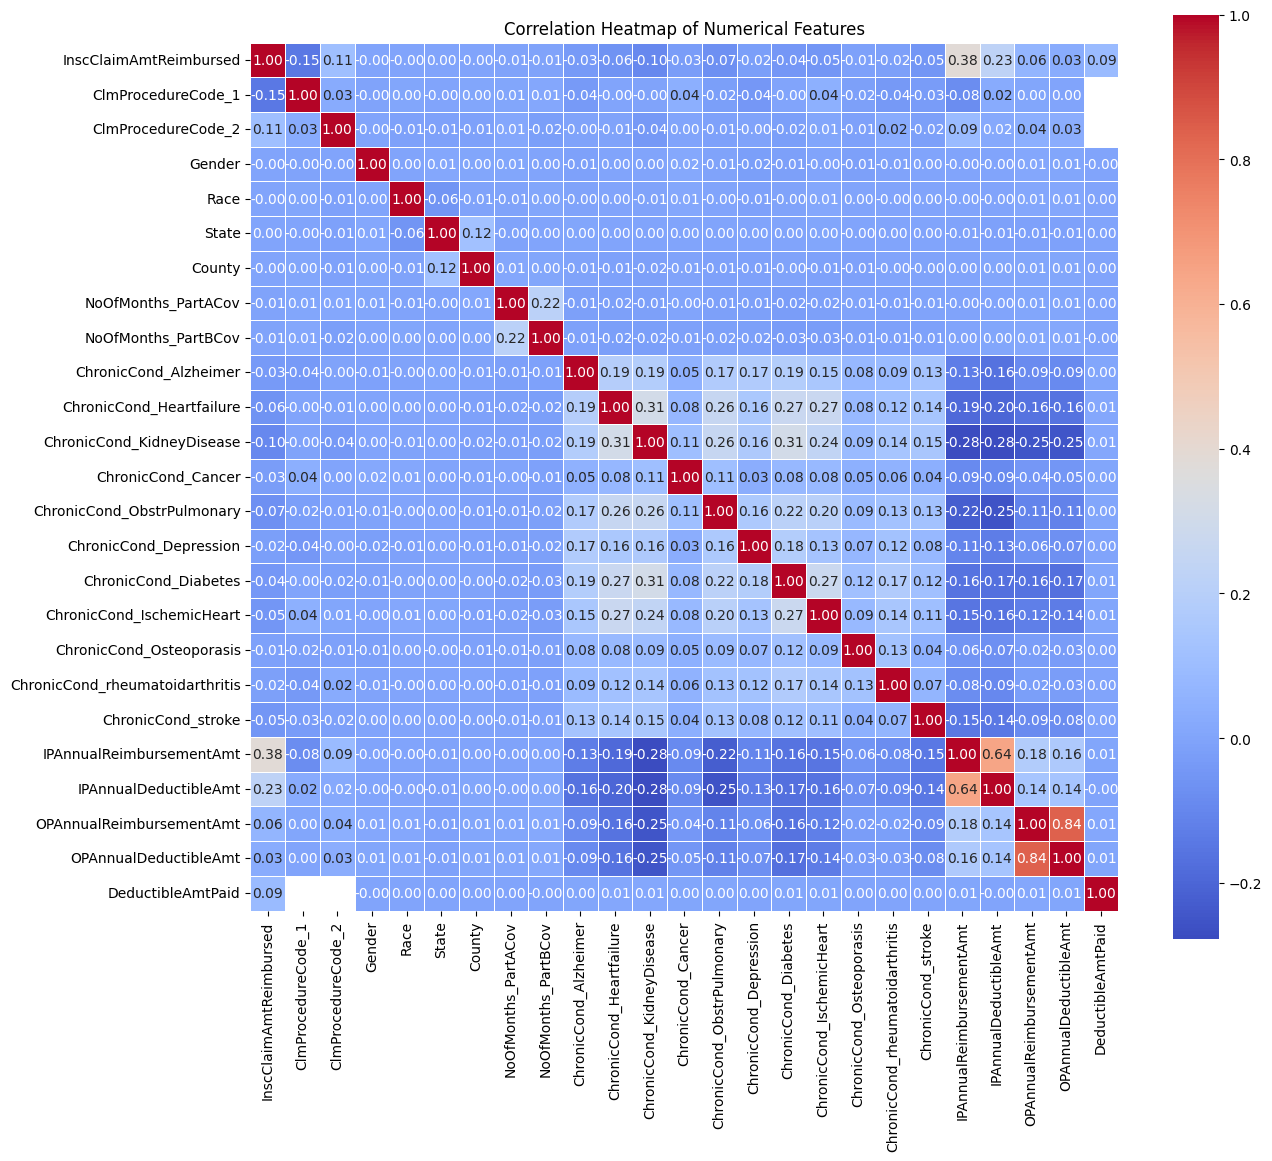

In [32]:
# Correlation Heatmap
plt.figure(figsize=(14,12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

##### Encoding

In [33]:
cols = ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'Provider']

for col in cols:
    print(f"\nColumn: {col}")
    print(f"Unique values count: {Train_Combined[col].nunique()}")
    print(f"Top 5 most frequent values:\n{Train_Combined[col].value_counts().head()}")
    print(f"Number of missing/unknown: {(Train_Combined[col] == 'Unknown').sum() + (Train_Combined[col] == 'Missing').sum()}")


Column: AttendingPhysician
Unique values count: 82063
Top 5 most frequent values:
AttendingPhysician
PHY330576    3930
PHY350277    1628
PHY412132    1321
PHY423534    1223
PHY314027    1200
Name: count, dtype: int64
Number of missing/unknown: 0

Column: OperatingPhysician
Unique values count: 35316
Top 5 most frequent values:
OperatingPhysician
Unknown      443764
PHY330576       424
PHY424897       293
PHY314027       256
PHY423534       250
Name: count, dtype: int64
Number of missing/unknown: 443764

Column: OtherPhysician
Unique values count: 46458
Top 5 most frequent values:
OtherPhysician
Unknown      358475
PHY412132      1247
PHY341578      1098
PHY338032      1070
PHY337425      1041
Name: count, dtype: int64
Number of missing/unknown: 358475

Column: Provider
Unique values count: 5410
Top 5 most frequent values:
Provider
PRV51459    8240
PRV53797    4739
PRV51574    4444
PRV53918    3588
PRV54895    3436
Name: count, dtype: int64
Number of missing/unknown: 0


In [34]:
print(f"{col} Unique Values - Train: {Train_Combined[col].nunique()}, Test: {Test_Combined[col].nunique()}")

Provider Unique Values - Train: 5410, Test: 1353


In [35]:
# Label Encoding

label_cols = ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'Provider']

for col in label_cols:
    le = LabelEncoder()
    
    # Combine Train & Test column values to fit encoder
    combined_vals = pd.concat([Train_Combined[col], Test_Combined[col]]).astype(str)
    le.fit(combined_vals)
    
    # Transform both datasets
    Train_Combined[col] = le.transform(Train_Combined[col].astype(str))
    Test_Combined[col] = le.transform(Test_Combined[col].astype(str))

print("Label Encoding completed successfully!")

Label Encoding completed successfully!


In [36]:
print(Train_Combined.columns.tolist())

['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode', 'DischargeDt', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'De

In [37]:
print(Test_Combined.columns.tolist())

['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode', 'DischargeDt', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'De

In [38]:
categorical_cols = ['Gender', 'Race', 'RenalDiseaseIndicator', 'PotentialFraud']

# For Train Data
cols_to_encode_train = [col for col in categorical_cols if col in Train_Combined.columns]
Train_Combined = pd.get_dummies(Train_Combined, columns=cols_to_encode_train, drop_first=True)

# For Test Data
cols_to_encode_test = [col for col in categorical_cols if col in Test_Combined.columns]
Test_Combined = pd.get_dummies(Test_Combined, columns=cols_to_encode_test, drop_first=True)

# Align columns
Train_Combined, Test_Combined = Train_Combined.align(Test_Combined, join='left', axis=1, fill_value=0)

In [39]:
label_cols_remaining = ['State', 'County', 'DiagnosisGroupCode', 'ClmAdmitDiagnosisCode',
                        'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
                        'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
                        'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
                        'ClmProcedureCode_1', 'ClmProcedureCode_2']

for col in label_cols_remaining:
    le = LabelEncoder()
    
    # Combine Train & Test values for consistency
    combined_vals = pd.concat([Train_Combined[col], Test_Combined[col]]).astype(str)
    le.fit(combined_vals)
    
    # Transform both datasets
    Train_Combined[col] = le.transform(Train_Combined[col].astype(str))
    Test_Combined[col] = le.transform(Test_Combined[col].astype(str))

print("Remaining Label Encoding completed successfully!")

Remaining Label Encoding completed successfully!


In [40]:
# Claim duration
Train_Combined['ClaimStartDt'] = pd.to_datetime(Train_Combined['ClaimStartDt'])
Train_Combined['ClaimEndDt'] = pd.to_datetime(Train_Combined['ClaimEndDt'])
Test_Combined['ClaimStartDt'] = pd.to_datetime(Test_Combined['ClaimStartDt'])
Test_Combined['ClaimEndDt'] = pd.to_datetime(Test_Combined['ClaimEndDt'])

Train_Combined['Claim_Duration'] = (Train_Combined['ClaimEndDt'] - Train_Combined['ClaimStartDt']).dt.days
Test_Combined['Claim_Duration'] = (Test_Combined['ClaimEndDt'] - Test_Combined['ClaimStartDt']).dt.days

In [41]:
# Length of Stay
Train_Combined['AdmissionDt'] = pd.to_datetime(Train_Combined['AdmissionDt'], errors='coerce')
Train_Combined['DischargeDt'] = pd.to_datetime(Train_Combined['DischargeDt'], errors='coerce')
Test_Combined['AdmissionDt'] = pd.to_datetime(Test_Combined['AdmissionDt'], errors='coerce')
Test_Combined['DischargeDt'] = pd.to_datetime(Test_Combined['DischargeDt'], errors='coerce')

Train_Combined['Length_of_Stay'] = (Train_Combined['DischargeDt'] - Train_Combined['AdmissionDt']).dt.days
Test_Combined['Length_of_Stay'] = (Test_Combined['DischargeDt'] - Test_Combined['AdmissionDt']).dt.days

In [42]:
# Age
Train_Combined['DOB'] = pd.to_datetime(Train_Combined['DOB'], errors='coerce')
Test_Combined['DOB'] = pd.to_datetime(Test_Combined['DOB'], errors='coerce')

Train_Combined['Age'] = Train_Combined['ClaimStartDt'].dt.year - Train_Combined['DOB'].dt.year
Test_Combined['Age'] = Test_Combined['ClaimStartDt'].dt.year - Test_Combined['DOB'].dt.year

In [43]:
# Deceased Flag
Train_Combined['DOD'] = pd.to_datetime(Train_Combined['DOD'], errors='coerce')
Test_Combined['DOD'] = pd.to_datetime(Test_Combined['DOD'], errors='coerce')

Train_Combined['Deceased_Flag'] = (Train_Combined['DOD'].notnull()) & (Train_Combined['ClaimStartDt'] > Train_Combined['DOD'])
Train_Combined['Deceased_Flag'] = Train_Combined['Deceased_Flag'].astype(int)

Test_Combined['Deceased_Flag'] = (Test_Combined['DOD'].notnull()) & (Test_Combined['ClaimStartDt'] > Test_Combined['DOD'])
Test_Combined['Deceased_Flag'] = Test_Combined['Deceased_Flag'].astype(int)

In [44]:
# Claim and Month/Year
Train_Combined['Claim_Month'] = Train_Combined['ClaimStartDt'].dt.month
Train_Combined['Claim_Year'] = Train_Combined['ClaimStartDt'].dt.year

Test_Combined['Claim_Month'] = Test_Combined['ClaimStartDt'].dt.month
Test_Combined['Claim_Year'] = Test_Combined['ClaimStartDt'].dt.year

In [45]:
# Number of Diagnoses & Procedures per Claim
Train_Combined['Num_Diagnoses'] = Train_Combined[[f'ClmDiagnosisCode_{i}' for i in range(1,10)]].notnull().sum(axis=1)
Test_Combined['Num_Diagnoses'] = Test_Combined[[f'ClmDiagnosisCode_{i}' for i in range(1,10)]].notnull().sum(axis=1)

Train_Combined['Num_Procedures'] = Train_Combined[[f'ClmProcedureCode_{i}' for i in range(1,3)]].notnull().sum(axis=1)
Test_Combined['Num_Procedures'] = Test_Combined[[f'ClmProcedureCode_{i}' for i in range(1,3)]].notnull().sum(axis=1)

In [46]:
# Chronic conditions sum
chronic_cols = [col for col in Train_Combined.columns if 'ChronicCond_' in col]

Train_Combined['Chronic_Cond_Sum'] = Train_Combined[chronic_cols].sum(axis=1)
Test_Combined['Chronic_Cond_Sum'] = Test_Combined[chronic_cols].sum(axis=1)

In [47]:
# Average Deductible/Reimbursement Amount per Claim
Train_Combined['Avg_Deductible'] = (Train_Combined['IPAnnualDeductibleAmt'] + Train_Combined['OPAnnualDeductibleAmt']) / 2
Test_Combined['Avg_Deductible'] = (Test_Combined['IPAnnualDeductibleAmt'] + Test_Combined['OPAnnualDeductibleAmt']) / 2

Train_Combined['Avg_Reimbursement'] = (Train_Combined['IPAnnualReimbursementAmt'] + Train_Combined['OPAnnualReimbursementAmt']) / 2
Test_Combined['Avg_Reimbursement'] = (Test_Combined['IPAnnualReimbursementAmt'] + Test_Combined['OPAnnualReimbursementAmt']) / 2

In [48]:
# Unique Beneficiary Count of Claims
beneficiary_claim_count = Train_Combined['BeneID'].value_counts().to_dict()
Train_Combined['Bene_Claim_Count'] = Train_Combined['BeneID'].map(beneficiary_claim_count)
Test_Combined['Bene_Claim_Count'] = Test_Combined['BeneID'].map(lambda x: beneficiary_claim_count.get(x, 0))

In [49]:
# Previous fraud indicator
provider_fraud = Train_Combined.groupby('Provider')['PotentialFraud_Yes'].max()
Train_Combined['Provider_Prev_Fraud'] = Train_Combined['Provider'].map(provider_fraud)
Test_Combined['Provider_Prev_Fraud'] = Test_Combined['Provider'].map(lambda x: provider_fraud.get(x, 0))

In [50]:
# One-hot encoding for claim month
Train_Combined = pd.get_dummies(Train_Combined, columns=['Claim_Month'], prefix='Month', drop_first=True)
Test_Combined = pd.get_dummies(Test_Combined, columns=['Claim_Month'], prefix='Month', drop_first=True)

Train_Combined, Test_Combined = Train_Combined.align(Test_Combined, join='left', axis=1, fill_value=0)

In [51]:
# Dropping the leakage feature
if 'ClaimStartDt' in Train_Combined.columns:
    Train_Combined['Claim_Month'] = Train_Combined['ClaimStartDt'].dt.month
if 'ClaimStartDt' in Test_Combined.columns:
    Test_Combined['Claim_Month'] = Test_Combined['ClaimStartDt'].dt.month

# Columns to drop (dates + identifiers + high-leakage features)
cols_to_drop = [
    'ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt',
    'DOB', 'DOD', 'ClaimID', 'BeneID', 
    'Provider_Prev_Fraud'  # <--- Dropping the leakage feature
]

# Drop from Train & Test if columns exist
Train_Combined.drop(columns=[col for col in cols_to_drop if col in Train_Combined.columns], inplace=True)
Test_Combined.drop(columns=[col for col in cols_to_drop if col in Test_Combined.columns], inplace=True)

print("Date, ID, and leakage columns dropped successfully!")

# Encoding 'Claim_Month' (recommended)
if 'Claim_Month' in Train_Combined.columns:
    Train_Combined = pd.get_dummies(Train_Combined, columns=['Claim_Month'], prefix='Month', drop_first=True)
if 'Claim_Month' in Test_Combined.columns:
    Test_Combined = pd.get_dummies(Test_Combined, columns=['Claim_Month'], prefix='Month', drop_first=True)

# Align columns after encoding
Train_Combined, Test_Combined = Train_Combined.align(Test_Combined, join='left', axis=1, fill_value=0)

print("Claim_Month encoding completed!")

# Save to new CSV files
Train_Combined.to_csv('Train_Cleaned_Encoded.csv', index=False)
Test_Combined.to_csv('Test_Cleaned_Encoded.csv', index=False)

print("New cleaned & encoded files saved successfully!")


Date, ID, and leakage columns dropped successfully!
Claim_Month encoding completed!
New cleaned & encoded files saved successfully!


##### Load encoded cleaned data

In [53]:
train_df = pd.read_csv('Train_Cleaned_Encoded.csv')
test_df = pd.read_csv('Test_Cleaned_Encoded.csv')

# Separate target
y = train_df['PotentialFraud_Yes']  # Assuming binary 0/1
X_train = train_df.drop('PotentialFraud_Yes', axis=1)
X_test = test_df.copy()  # No target column in test set

##### Normalization

In [54]:
# Separate target variable
y = train_df['PotentialFraud_Yes']
X_train = train_df.drop('PotentialFraud_Yes', axis=1)

# Remove 'PotentialFraud_Yes' from test if it exists
if 'PotentialFraud_Yes' in test_df.columns:
    X_test = test_df.drop('PotentialFraud_Yes', axis=1)
else:
    X_test = test_df.copy()

# Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Normalization successful!")

Normalization successful!


##### Validation

In [55]:
# Split for validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Train Random Forest (as an example)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_tr, y_tr)

# Evaluate
y_pred = rf.predict(X_val)
print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.82      0.94      0.88     69083
        True       0.87      0.67      0.76     42560

    accuracy                           0.84    111643
   macro avg       0.85      0.80      0.82    111643
weighted avg       0.84      0.84      0.83    111643

ROC AUC Score: 0.8038190223792585


##### Feature Importance

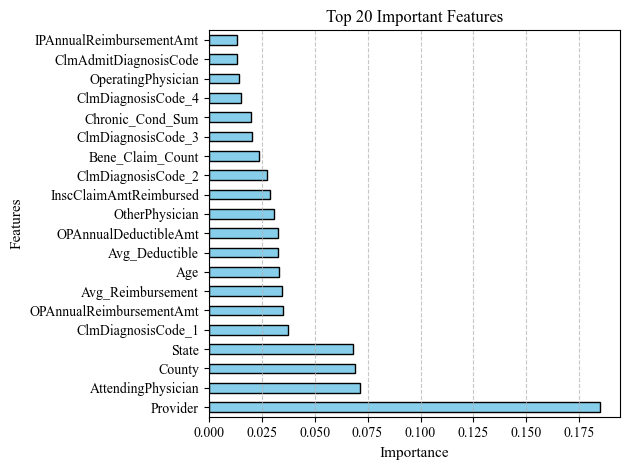

In [56]:
# Set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Create the feature importance series
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

# Plot the top 20 important features
ax = feature_importances.nlargest(20).plot(kind='barh', color='skyblue', edgecolor='black')

# Set the title and labels with some customization
plt.title("Top 20 Important Features", fontsize=12)
plt.xlabel("Importance", fontsize=11)
plt.ylabel("Features", fontsize=11)

# Add gridlines and adjust the style for a cleaner look
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [57]:
# Predict
test_preds = rf.predict(X_test_scaled)

# Prepare submission (no IDs, so index-based submission)
submission = pd.DataFrame({
    'Index': test_df.index,
    'PotentialFraud': ['Yes' if pred == 1 else 'No' for pred in test_preds]
})

submission.to_csv('Final_Submission_Normalized.csv', index=False)
print("Submission file saved successfully!")

Submission file saved successfully!


In [58]:
# Impute missing values with the median of each column
imputer = SimpleImputer(strategy='median')

# Create a pipeline with imputer and logistic regression
model_lr = make_pipeline(imputer, LogisticRegression(max_iter=1000))



# Define scoring metric
scoring = 'f1'

# Create stratified k-fold cross validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores_lr = cross_val_score(model_lr, X_train_scaled, y, cv=skf, scoring=scoring, n_jobs=-1, verbose=1)
print(f"Logistic Regression - Cross-Validated F1 Scores: {cv_scores_lr}")
print(f"Logistic Regression - Mean F1 Score: {cv_scores_lr.mean():.4f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.3s remaining:   31.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.6s finished


Logistic Regression - Cross-Validated F1 Scores: [0.27434268 0.27556085 0.2750741  0.27521125 0.27796003]
Logistic Regression - Mean F1 Score: 0.2756


In [59]:
# Define the XGBoost model with class_weight='balanced' for handling class imbalance
model_xgb = XGBClassifier(scale_pos_weight=1, random_state=42, use_label_encoder=False, eval_metric='logloss')

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metric
scoring = make_scorer(f1_score, pos_label=True)

# Perform cross-validation
cv_scores_xgb = cross_val_score(model_xgb, X_train_scaled, y, cv=skf, scoring=scoring, n_jobs=-1)

# Print the results
print(f"XGBoost - Cross-Validated F1 Scores: {cv_scores_xgb}")
print(f"XGBoost - Mean F1 Score: {cv_scores_xgb.mean():.4f}")

XGBoost - Cross-Validated F1 Scores: [0.86292854 0.86242614 0.85998235 0.86153921 0.86197245]
XGBoost - Mean F1 Score: 0.8618


In [60]:
# Define the LightGBM model with class_weight='balanced' for handling class imbalance
model_lgb = lgb.LGBMClassifier(class_weight='balanced', random_state=42)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metric
scoring = make_scorer(f1_score, pos_label=True)

# Perform cross-validation
cv_scores_lgb = cross_val_score(model_lgb, X_train_scaled, y, cv=skf, scoring=scoring, n_jobs=-1)

# Print the results
print(f"LightGBM - Cross-Validated F1 Scores: {cv_scores_lgb}")
print(f"LightGBM - Mean F1 Score: {cv_scores_lgb.mean():.4f}")

LightGBM - Cross-Validated F1 Scores: [0.8151355  0.81414621 0.81604741 0.81779418 0.81808693]
LightGBM - Mean F1 Score: 0.8162


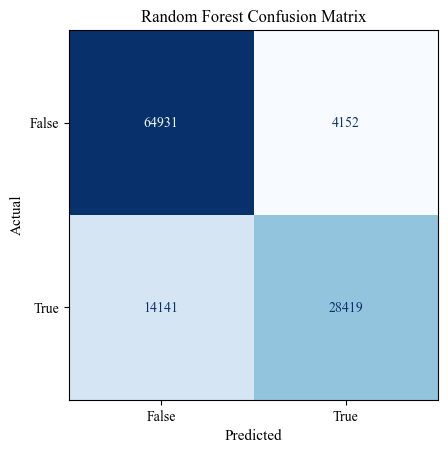

In [61]:
# Confussion matrix
# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['False', 'True'])

# Set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Plot the confusion matrix with a customized color map and additional styling
disp.plot(cmap='Blues', values_format='d', colorbar=False)

# Set the title and axis labels with customization
plt.title("Random Forest Confusion Matrix", fontsize=12)
plt.xlabel("Predicted", fontsize=11)
plt.ylabel("Actual", fontsize=11)

# Add gridlines for clarity
plt.grid(False)

##### Precision Recall Curve

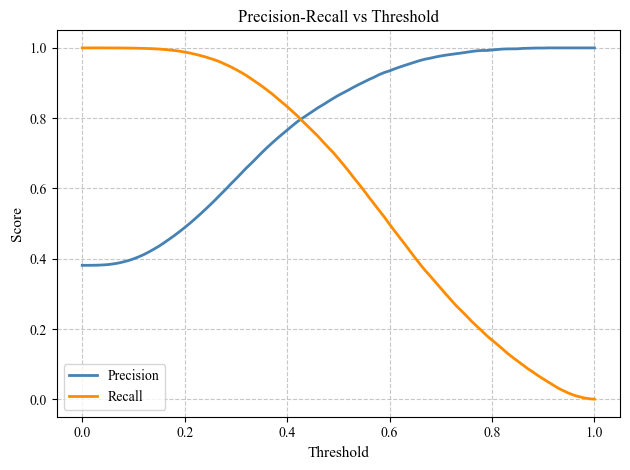

In [62]:
# Get predicted probabilities
y_scores = rf.predict_proba(X_val)[:, 1]

# Compute precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

# Set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Plot Precision and Recall with different line colors
plt.plot(thresholds, precisions[:-1], label='Precision', color='steelblue', linewidth=2)
plt.plot(thresholds, recalls[:-1], label='Recall', color='darkorange', linewidth=2)

# Add labels, title, and legend
plt.xlabel('Threshold', fontsize=11)
plt.ylabel('Score', fontsize=11)
plt.title('Precision-Recall vs Threshold', fontsize=12)
plt.legend()

# Show grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [63]:
# Print classification report
print("Classification Report:\n", classification_report(y_val, y_pred))

# Print ROC AUC score
print(f"ROC AUC Score: {roc_auc_score(y_val, y_pred):.4f}")

Classification Report:
               precision    recall  f1-score   support

       False       0.82      0.94      0.88     69083
        True       0.87      0.67      0.76     42560

    accuracy                           0.84    111643
   macro avg       0.85      0.80      0.82    111643
weighted avg       0.84      0.84      0.83    111643

ROC AUC Score: 0.8038


In [64]:
tn, fp, fn, tp = cm.ravel()

specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Specificity (True Negative Rate): {specificity:.2f}")
print(f"Sensitivity (Recall / True Positive Rate): {sensitivity:.2f}")

Specificity (True Negative Rate): 0.94
Sensitivity (Recall / True Positive Rate): 0.67


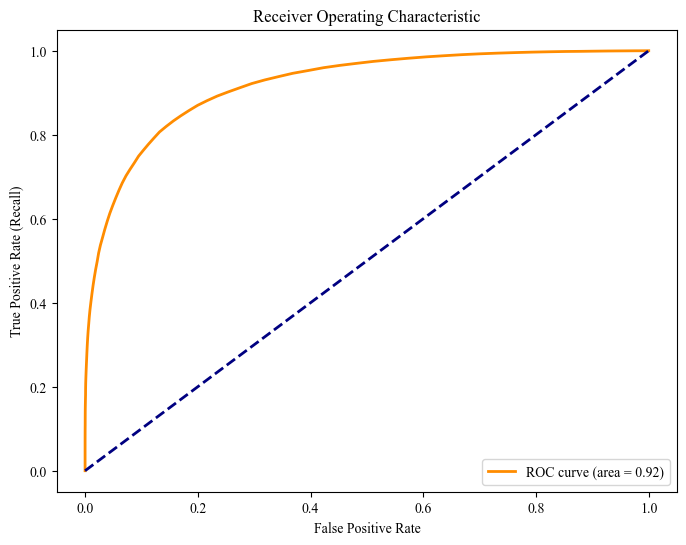

In [66]:
from sklearn.metrics import roc_curve, auc

# ROC and AUC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

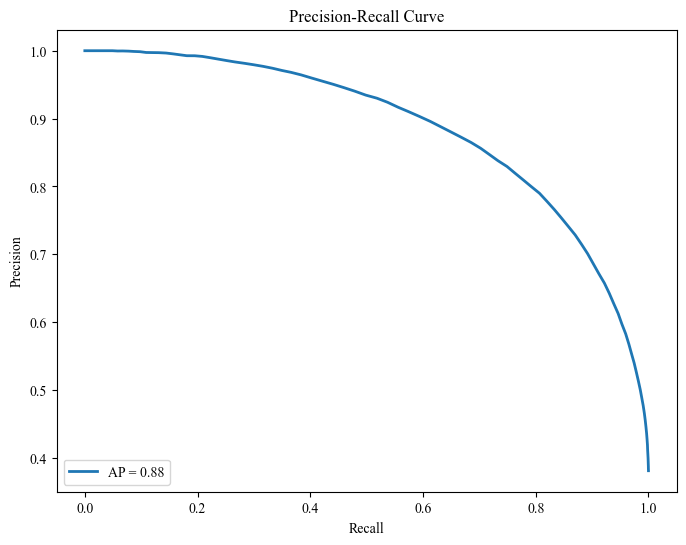

In [67]:
# Precision-Recall Curve

precision, recall, thresholds = precision_recall_curve(y_val, y_scores)
average_precision = average_precision_score(y_val, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, lw=2, label=f'AP = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()